#  Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = '/content/drive/MyDrive/원티드 프리온보딩/기업과제/과제3/DATA/'

# Install Packages & Load Libraries

In [ ]:
!pip install transformers sentence-transformers 

     |████████████████████████████████| 3.8 MB 9.2 MB/s 
     |████████████████████████████████| 79 kB 7.2 MB/s 
     |████████████████████████████████| 596 kB 47.1 MB/s 
     |████████████████████████████████| 895 kB 52.9 MB/s 
     |████████████████████████████████| 6.5 MB 38.5 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 1.2 MB 46.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=af1ad36e8b834277ab42b622ab4180a8f60e1046a894645dcce75558495961f5
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import warnings
import sys
import tqdm
import math
import logging
from scipy.stats import pearsonr
from sklearn.metrics import f1_score
from typing import Dict, Type, Callable, List
from sklearn.model_selection import train_test_split

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import LoggingHandler
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.readers import InputExample

In [ ]:
print(transformers.__version__)

4.17.0


# Device

In [ ]:
if torch.cuda.is_available():
	device_count = torch.cuda.device_count()
	print("device_count: {}".format(device_count))
	for device_num in range(device_count):
		print("device {} capability {}".format(device_num,torch.cuda.get_device_capability(device_num)))
		print("device {} name {}".format(device_num, torch.cuda.get_device_name(device_num)))
else:
	print("no cuda device")

device_count: 1
device 0 capability (6, 0)
device 0 name Tesla P100-PCIE-16GB


# Reproducibility

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
set_seed(3)

# Logger

In [ ]:
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
    handlers=[LoggingHandler()],
)

# Model

In [ ]:
model_name = "klue/roberta-base"
train_batch_size = 32
num_epochs = 4
model_save_path = DATA_PATH + "/OUTPUT/" + model_name 
model = CrossEncoder(model_name, num_labels=1) # for regression

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classif

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

2022-03-23 16:34:26 - Use pytorch device: cuda


# Load Dataset

In [ ]:
with open(DATA_PATH + 'klue-sts-v1.1/klue-sts-v1.1_train.json', encoding='utf-8') as train_file:
    raw_train_df = pd.read_json(train_file)

with open(DATA_PATH + 'klue-sts-v1.1/klue-sts-v1.1_dev.json', encoding='utf-8') as test_file:
    raw_test_df = pd.read_json(test_file)

In [ ]:
print(raw_train_df.shape)
raw_train_df.head()

(11668, 6)


,guid,source,sentence1,sentence2,labels,annotations
0,klue-sts-v1_train_00000,airbnb-rtt,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.,"{'label': 3.7, 'real-label': 3.714285714285714...","{'agreement': '0:0:0:2:5:0', 'annotators': ['0..."
1,klue-sts-v1_train_00001,policy-sampled,위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다.,시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다.,"{'label': 0.0, 'real-label': 0.0, 'binary-labe...","{'agreement': '5:0:0:0:0:0', 'annotators': ['1..."
2,klue-sts-v1_train_00002,paraKQC-sampled,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘.,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘,"{'label': 0.30000000000000004, 'real-label': 0...","{'agreement': '4:2:0:0:0:0', 'annotators': ['1..."
3,klue-sts-v1_train_00003,policy-sampled,"긴급 고용안정지원금은 지역고용대응 등 특별지원금, 지자체별 소상공인 지원사업, 취업...","고용보험이 1차 고용안전망이라면, 국민취업지원제도는 2차 고용안전망입니다.","{'label': 0.6000000000000001, 'real-label': 0....","{'agreement': '4:2:1:0:0:0', 'annotators': ['1..."
4,klue-sts-v1_train_00004,airbnb-rtt,"호스트의 답장이 늦으나, 개선될 것으로 보입니다.",호스트 응답이 늦었지만 개선될 것으로 보입니다.,"{'label': 4.7, 'real-label': 4.714285714285714...","{'agreement': '0:0:0:0:2:5', 'annotators': ['1..."


In [ ]:
print(raw_test_df.shape)
raw_test_df.head()

(519, 6)


,guid,source,sentence1,sentence2,labels,annotations
0,klue-sts-v1_dev_00000,airbnb-rtt,무엇보다도 호스트분들이 너무 친절하셨습니다.,"무엇보다도, 호스트들은 매우 친절했습니다.","{'label': 4.9, 'real-label': 4.857142857142857...","{'agreement': '0:0:0:0:1:6', 'annotators': ['1..."
1,klue-sts-v1_dev_00001,airbnb-sampled,주요 관광지 모두 걸어서 이동가능합니다.,위치는 피렌체 중심가까지 걸어서 이동 가능합니다.,"{'label': 1.4, 'real-label': 1.428571428571429...","{'agreement': '0:4:3:0:0:0', 'annotators': ['1..."
2,klue-sts-v1_dev_00002,policy-sampled,학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...,"{'label': 1.3, 'real-label': 1.285714285714286...","{'agreement': '0:5:2:0:0:0', 'annotators': ['0..."
3,klue-sts-v1_dev_00003,airbnb-rtt,"다만, 도로와 인접해서 거리의 소음이 들려요.","하지만, 길과 가깝기 때문에 거리의 소음을 들을 수 있습니다.","{'label': 3.7, 'real-label': 3.714285714285714...","{'agreement': '0:0:0:2:5:0', 'annotators': ['1..."
4,klue-sts-v1_dev_00004,paraKQC-para,형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요.,가족 모임 일정은 바꾸지 말도록 하십시오.,"{'label': 2.5, 'real-label': 2.5, 'binary-labe...","{'agreement': '1:0:1:3:1:0', 'annotators': ['0..."


# EDA & Pre-processing

In [ ]:
# only get the real-label 
raw_train_df['label'] =  [d.get('real-label') for d in raw_train_df.labels]
raw_test_df['label'] =  [d.get('real-label') for d in raw_test_df.labels]

# drop unnecessary columns
train_df = raw_train_df.drop(['guid', 'labels', 'annotations'], axis=1)  
test_df = raw_test_df.drop(['guid', 'labels', 'annotations'], axis=1)  

In [ ]:
train_df.describe(include='all')

,source,sentence1,sentence2,label
count,11668,11668,11668,11668.000000
unique,6,11657,11654,NaN
top,airbnb-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...",NaN
freq,2726,5,4,NaN
mean,NaN,NaN,NaN,2.216561
std,NaN,NaN,NaN,1.749921
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,0.200000
50%,NaN,NaN,NaN,2.666667
75%,NaN,NaN,NaN,3.857143


In [ ]:
test_df.describe(include='all')

,source,sentence1,sentence2,label
count,519,519,519,519.000000
unique,6,519,519,NaN
top,airbnb-sampled,무엇보다도 호스트분들이 너무 친절하셨습니다.,"무엇보다도, 호스트들은 매우 친절했습니다.",NaN
freq,148,1,1,NaN
mean,NaN,NaN,NaN,2.484778
std,NaN,NaN,NaN,1.477751
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,1.154762
50%,NaN,NaN,NaN,2.571429
75%,NaN,NaN,NaN,3.800000


In [ ]:
train_df.source.value_counts()

airbnb-rtt         2726
airbnb-sampled     2645
paraKQC-sampled    2050
paraKQC-para       1903
policy-sampled     1245
policy-rtt         1099
Name: source, dtype: int64

In [ ]:
# unify source values
train_df['source'] = train_df['source'].str.rsplit('-').str[0]
test_df['source'] = test_df['source'].str.rsplit('-').str[0]

In [ ]:
# check duplicates (sentences - label)
print(train_df[train_df.duplicated(['sentence1', 'sentence2', 'label'], keep=False)].sort_values(['sentence1', 'sentence2', 'label']).shape)
train_df[train_df.duplicated(['sentence1', 'sentence2', 'label'],keep=False)].sort_values(['sentence1', 'sentence2', 'label'])

(10, 4)


,source,sentence1,sentence2,label
1514,policy,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...",4.714286
5292,policy,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...",4.714286
3872,policy,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...",4.857143
11112,policy,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...",4.857143
7045,policy,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...",4.000000
10908,policy,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...",4.000000
5139,policy,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...",4.571429
10939,policy,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...",4.571429
1661,airbnb,택시타고 공항갔을 때 20유로로 15분내에 도착했었어요.,"택시를 타고 공항에 갔을 때, 15분만에 20유로에 도착했습니다.",4.666667
1715,airbnb,택시타고 공항갔을 때 20유로로 15분내에 도착했었어요.,"택시를 타고 공항에 갔을 때, 15분만에 20유로에 도착했습니다.",4.666667


In [ ]:
# remove duplicates by averaging label values 
uni_train_df = train_df.groupby(['source', 'sentence1', 'sentence2']).mean().reset_index()
uni_train_df.shape

(11661, 4)

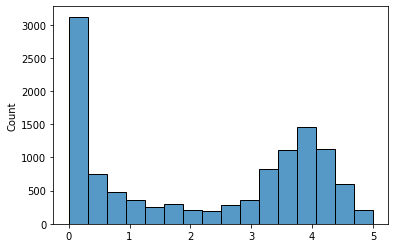

In [ ]:
# train data - label distribution 
sns.histplot(uni_train_df.label.tolist())
plt.show()

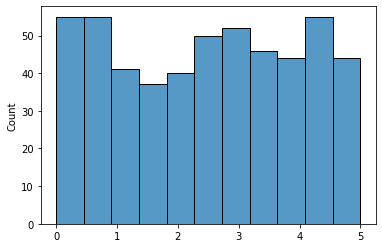

In [ ]:
# test data - label distribution
sns.histplot(test_df.label.tolist())
plt.show()

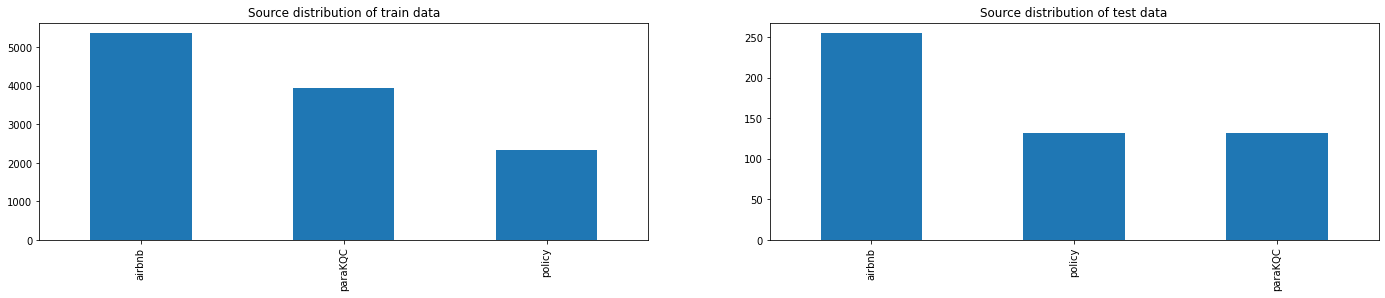

In [ ]:
# source distribution
fig, ax = plt.subplots(1, 2, figsize=(24,4))
uni_train_df.source.value_counts().plot(kind='bar', ax=ax[0], title="Source distribution of train data") 
test_df.source.value_counts().plot(kind='bar', ax=ax[1], title="Source distribution of test data") 
plt.show()

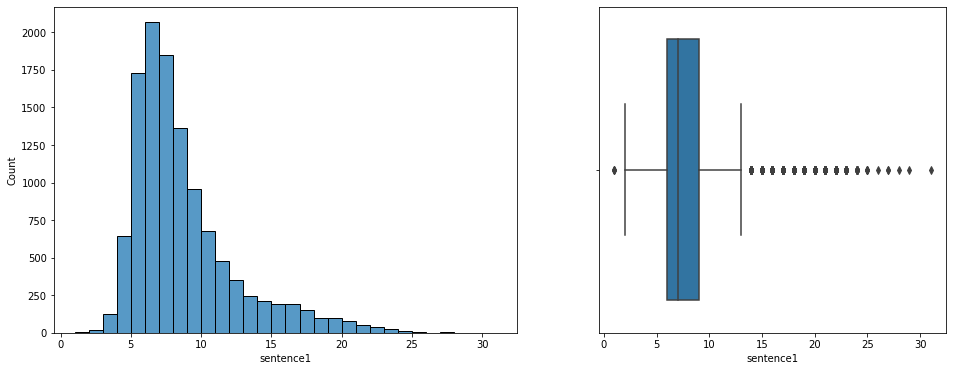

In [ ]:
# train data - sen1 length
train_sen1_len = uni_train_df['sentence1'].apply(lambda x:len(x.split(' ')))
warnings.filterwarnings("ignore")
fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw=dict(width_ratios=[4, 3]))
sns.histplot(train_sen1_len, binwidth=1, ax=axs[0])
sns.boxplot(train_sen1_len, ax=axs[1])
plt.show()

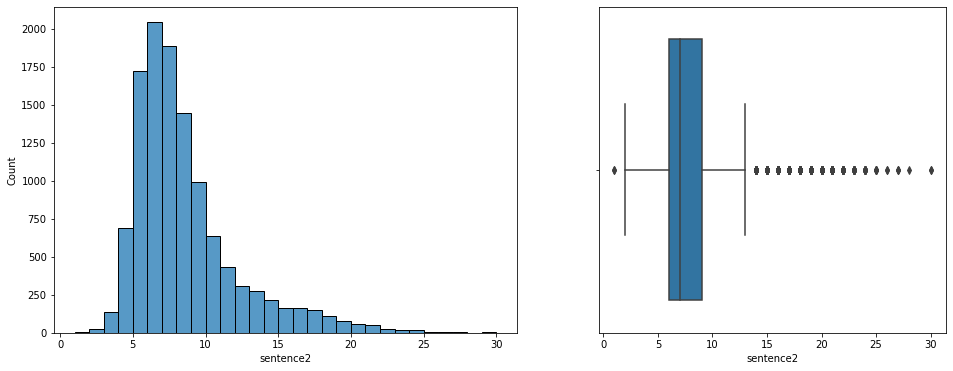

In [ ]:
# train data - sen2 length
train_sen2_len = uni_train_df['sentence2'].apply(lambda x:len(x.split(' ')))
warnings.filterwarnings("ignore")
fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw=dict(width_ratios=[4, 3]))
sns.histplot(train_sen2_len, binwidth=1, ax=axs[0])
sns.boxplot(train_sen2_len, ax=axs[1])
plt.show()

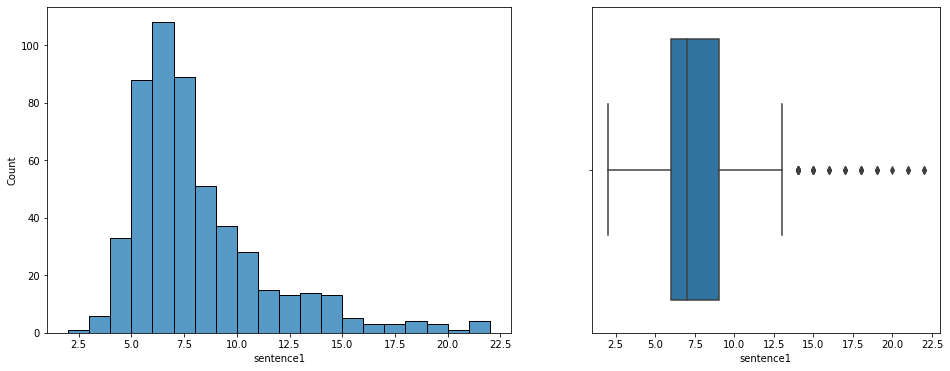

In [ ]:
# test data - sen1 length
test_sen1_len = test_df['sentence1'].apply(lambda x:len(x.split(' ')))
warnings.filterwarnings("ignore")
fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw=dict(width_ratios=[4, 3]))
sns.histplot(test_sen1_len, binwidth=1, ax=axs[0])
sns.boxplot(test_sen1_len, ax=axs[1])
plt.show()

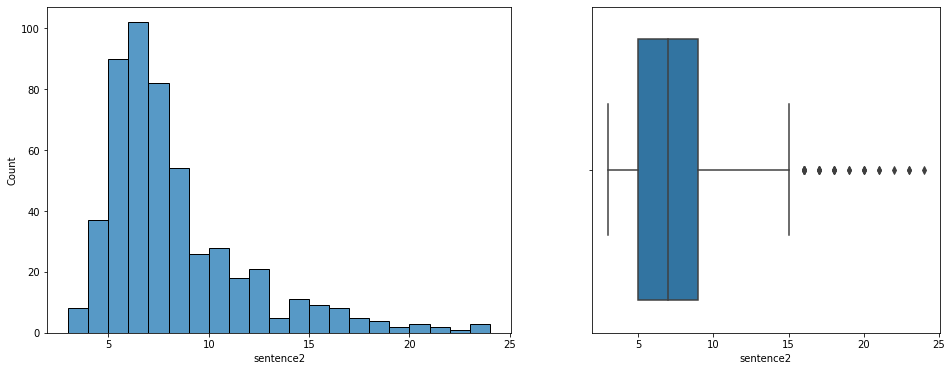

In [ ]:
# test data - sen2 length
test_sen2_len = test_df['sentence2'].apply(lambda x:len(x.split(' ')))
warnings.filterwarnings("ignore")
fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw=dict(width_ratios=[4, 3]))
sns.histplot(test_sen2_len, binwidth=1, ax=axs[0])
sns.boxplot(test_sen2_len, ax=axs[1])
plt.show()

# Data Augmentation: BM25 Sampling

In [ ]:
# Load augmented data 
aug_data = pd.read_csv(DATA_PATH + "augdata.csv")

In [ ]:
print(aug_data.shape)
aug_data.head()

(35927, 3)


,sentence1,sentence2,label
0,세탁기와 건조기는 사용이 편리하고 세탁 세제가 제공됩니다.,세탁 건조기는 절대 쓰지마,2.642680
1,결제 메일의 내용으로 부터 무엇을 알 수 있나요?,결제 메일의 내용으로부터 어떤 정보를 얻을 수 있나요?,4.196195
2,결제 메일의 내용으로 부터 무엇을 알 수 있나요?,결제 메일을 통해 어떤 걸 알 수 있나요?,4.159386
3,나한테 지금 거실 온도 몇도인지 좀 알려줄래?,지금 거실 온도 몇도인지 알고싶어,3.850049
4,나한테 지금 거실 온도 몇도인지 좀 알려줄래?,저기요 지금 거실 온도 몇도인지 확인하는 방법 좀 알려주세요,3.705963


In [ ]:
# drop the source column of the original train data
uni_train_df.drop(['source'], axis=1, inplace=True)  

In [ ]:
# desired train data size after augmentation: 5000 * 5 = 25000
# train:valid = 25000: 2500
split_train_df, split_valid_df = train_test_split(uni_train_df, test_size=2500, random_state=3)

In [ ]:
print(split_train_df.shape)
print(split_valid_df.shape)

(9161, 3)
(2500, 3)


In [ ]:
def get_range_len(data_frame):
    sim0_1 = data_frame[(data_frame['label'] >= 0.0) & (data_frame['label'] < 1.0)].shape[0]
    sim1_2 = data_frame[(data_frame['label'] >= 1.0) & (data_frame['label'] < 2.0)].shape[0]
    sim2_3 = data_frame[(data_frame['label'] >= 2.0) & (data_frame['label'] < 3.0)].shape[0]
    sim3_4 = data_frame[(data_frame['label'] >= 3.0) & (data_frame['label'] < 4.0)].shape[0]
    sim4_5 = data_frame[(data_frame['label'] >= 4.0) & (data_frame['label'] <= 5.0)].shape[0]
    return sim0_1,sim1_2, sim2_3, sim3_4, sim4_5

In [ ]:
train_ratio = get_range_len(split_train_df)
print(train_ratio)

(3419, 722, 627, 2250, 2143)


In [ ]:
aug_ratio = get_range_len(aug_data)
print(aug_ratio)

(11752, 7041, 4477, 6190, 6467)


In [ ]:
aug_sim0_1 = aug_data[(aug_data['label'] >= 0.0) & (aug_data['label'] < 1.0)].sample(n=5000-train_ratio[0], random_state=3)
aug_sim1_2 = aug_data[(aug_data['label'] >= 1.0) & (aug_data['label'] < 2.0)].sample(n=5000-train_ratio[1], random_state=3)
aug_sim2_3 = aug_data[(aug_data['label'] >= 2.0) & (aug_data['label'] < 3.0)].sample(n=5000-train_ratio[2], random_state=3)
aug_sim3_4 = aug_data[(aug_data['label'] >= 3.0) & (aug_data['label'] < 4.0)].sample(n=5000-train_ratio[3], random_state=3)
aug_sim4_5 = aug_data[(aug_data['label'] >= 4.0) & (aug_data['label'] <= 5.0)].sample(n=5000-train_ratio[4], random_state=3)

In [ ]:
aug_train_df = pd.concat([split_train_df, aug_sim0_1, aug_sim1_2, aug_sim2_3, aug_sim3_4, aug_sim4_5])
print(aug_train_df.shape)
aug_train_df.tail(3)

(25000, 3)


,sentence1,sentence2,label
35382,별표를 하려면 보낸 메일함에서 어떻게 해야해?,보낸 메일함에서 메일에 별표를 하고 싶은데 어떻게 하는거야?,4.228279
32666,한라산에 눈 아직 오는 중이야? 아니면 그쳤어?,지금 한라산에 눈이 오는 중인지 아니면 그쳤는지 알고싶습니다.,4.000446
22113,제가 지메일 계정을 몇개 만들었었나요?,내가 지메일 계정을 몇개 만들었더라?,4.490580


In [ ]:
new_train_ratio = get_range_len(aug_train_df)
print(new_train_ratio)

(5000, 5000, 5000, 5000, 5000)


In [ ]:
aug_train_df.duplicated().any()

False

In [ ]:
# we won't use the augmented data 
new_train_df, valid_df = train_test_split(uni_train_df, test_size=0.1, random_state=3)

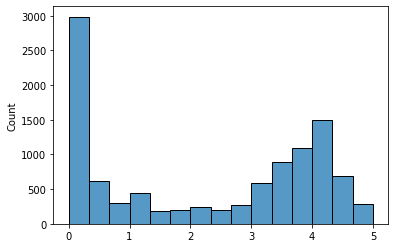

In [ ]:
# train data - label distribution 
sns.histplot(new_train_df.label.tolist())
plt.show()

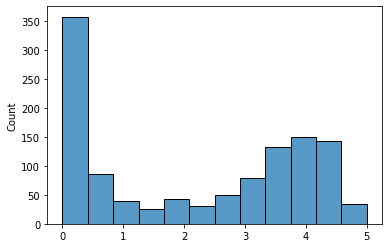

In [ ]:
# validation data - label distribution 
sns.histplot(valid_df.label.tolist())
plt.show()

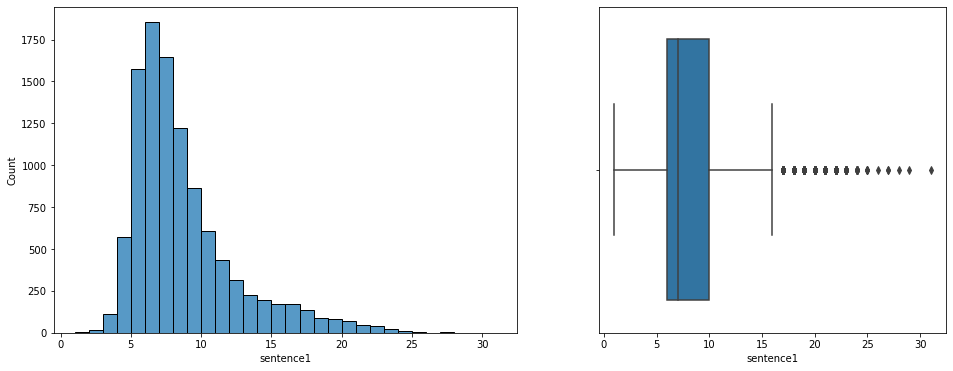

In [ ]:
# train data - sen1 length
train_sen1_len = new_train_df['sentence1'].apply(lambda x:len(x.split(' ')))
warnings.filterwarnings("ignore")
fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw=dict(width_ratios=[4, 3]))
sns.histplot(train_sen1_len, binwidth=1, ax=axs[0])
sns.boxplot(train_sen1_len, ax=axs[1])
plt.show()

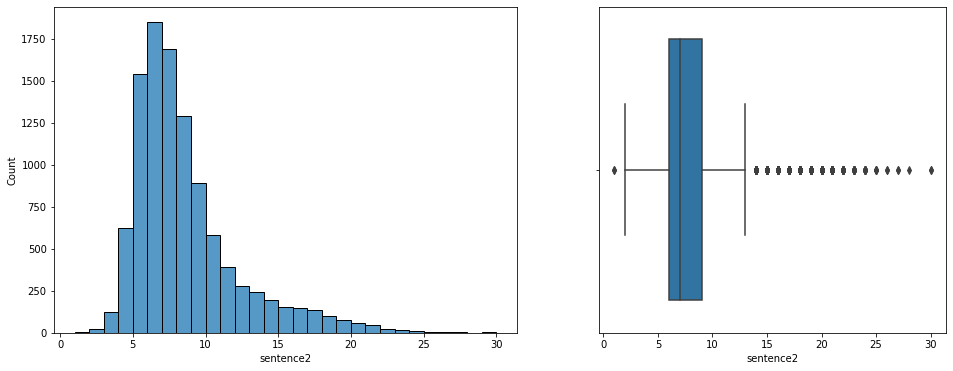

In [ ]:
# train data - sen2 length
train_sen2_len = new_train_df['sentence2'].apply(lambda x:len(x.split(' ')))
warnings.filterwarnings("ignore")
fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw=dict(width_ratios=[4, 3]))
sns.histplot(train_sen2_len, binwidth=1, ax=axs[0])
sns.boxplot(train_sen2_len, ax=axs[1])
plt.show()

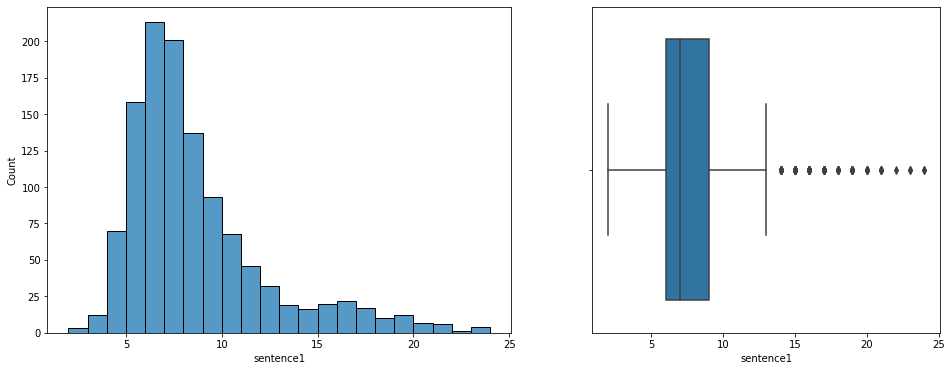

In [ ]:
# validation data - sen1 length
valid_sen1_len = valid_df['sentence1'].apply(lambda x:len(x.split(' ')))
warnings.filterwarnings("ignore")
fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw=dict(width_ratios=[4, 3]))
sns.histplot(valid_sen1_len, binwidth=1, ax=axs[0])
sns.boxplot(valid_sen1_len, ax=axs[1])
plt.show()

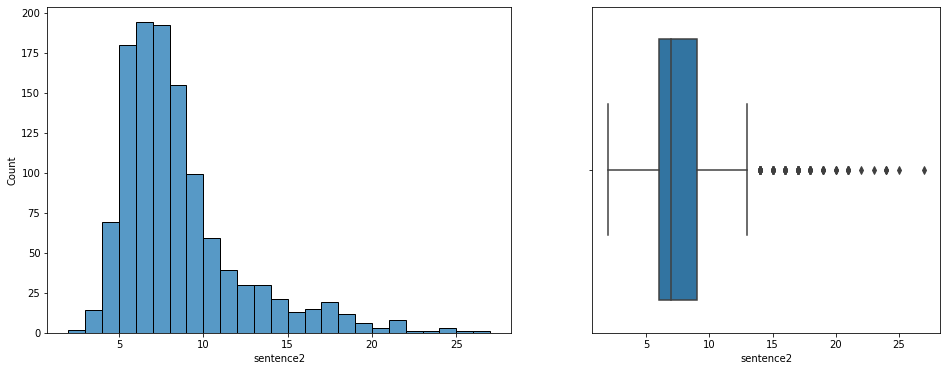

In [ ]:
# validation data - sen2 length
valid_sen2_len = valid_df['sentence2'].apply(lambda x:len(x.split(' ')))
warnings.filterwarnings("ignore")
fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw=dict(width_ratios=[4, 3]))
sns.histplot(valid_sen2_len, binwidth=1, ax=axs[0])
sns.boxplot(valid_sen2_len, ax=axs[1])
plt.show()

# Data Preparation

In [ ]:
class CustomDataset(Dataset):

  def __init__(self, s1, s2, label) -> None:
      self.s1 = s1
      self.s2 = s2
      self.label = label

  def __len__(self):
      return len(self.label)

  def __getitem__(self, idx):
      return [self.s1[idx], self.s2[idx]], self.label[idx]

In [ ]:
train_dataset = CustomDataset(new_train_df.sentence1.tolist(), new_train_df.sentence2.tolist(), new_train_df.label.tolist())
valid_dataset = CustomDataset(valid_df.sentence1.tolist(), valid_df.sentence2.tolist(), valid_df.label.tolist())
test_dataset = CustomDataset(test_df.sentence1.tolist(), test_df.sentence2.tolist(), test_df.label.tolist())

In [ ]:
def make_samples(dataset_name): 
    samples_list = []
    for example in dataset_name:
        score = float(example[1]) / 5.0  # scale normalization: 0.0 ~ 1.0 
        in_example = InputExample(texts=example[0], label=score)
        samples_list.append(in_example)
    return samples_list

In [ ]:
train_samples = make_samples(train_dataset)
valid_samples = make_samples(valid_dataset)
test_samples = make_samples(test_dataset)

In [ ]:
train_dataloader = DataLoader(
    train_samples,
    shuffle=True,
    batch_size=train_batch_size,
)

# Fine-tuning 

In [ ]:
# customize evaluator 
eval_logger = logging.getLogger(__name__)

class PearsonEvaluator:

    def __init__(self, sentence_pairs: List[List[str]], scores: List[float], name: str=''):
        self.sentence_pairs = sentence_pairs
        self.scores = scores
        self.name = name

    @classmethod
    def from_input_examples(cls, examples: List[InputExample], **kwargs):
        sentence_pairs = []
        scores = []

        for example in examples:
            sentence_pairs.append(example.texts)
            scores.append(example.label)
        return cls(sentence_pairs, scores, **kwargs)

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:
        if epoch != -1:
            if steps == -1:
                out_txt = " after epoch {}:".format(epoch)
            else:
                out_txt = " in epoch {} after {} steps:".format(epoch, steps)
        else:
            out_txt = ":"

        eval_logger.info("PearsonEvaluator: Evaluating the model on " + self.name + " dataset" + out_txt)
        pred_scores = model.predict(self.sentence_pairs, convert_to_numpy=True, show_progress_bar=False)
        eval_pearson, _ = pearsonr(self.scores, pred_scores)
        eval_logger.info("Correlation:\tPearson: {:.4f}".format(eval_pearson))
        return eval_pearson

In [ ]:
evaluator = PearsonEvaluator.from_input_examples(
    valid_samples,
    name="sts-valid",
)

In [ ]:
warmup_steps = math.ceil(len(train_dataloader) * num_epochs  * 0.1)  # 10% of train data for warm-up
logging.info(f"Warmup-steps: {warmup_steps}")

2022-03-23 16:34:34 - Warmup-steps: 132


In [ ]:
# train our model and get validation scores
model.fit(
    train_dataloader=train_dataloader,
    evaluator=evaluator,
    epochs=num_epochs,
    evaluation_steps=1000,
    warmup_steps=warmup_steps,
    optimizer_params={'lr': 2e-5},
    weight_decay=0.01,
    output_path=model_save_path,
)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/328 [00:00<?, ?it/s]

2022-03-23 16:36:22 - PearsonEvaluator: Evaluating the model on sts-valid dataset after epoch 0:
2022-03-23 16:36:25 - Correlation:	Pearson: 0.9767
2022-03-23 16:36:25 - Save model to /content/drive/MyDrive/원티드 프리온보딩/기업과제/과제3/DATA//OUTPUT/klue/roberta-base


Iteration:   0%|          | 0/328 [00:00<?, ?it/s]

2022-03-23 16:38:02 - PearsonEvaluator: Evaluating the model on sts-valid dataset after epoch 1:
2022-03-23 16:38:06 - Correlation:	Pearson: 0.9793
2022-03-23 16:38:06 - Save model to /content/drive/MyDrive/원티드 프리온보딩/기업과제/과제3/DATA//OUTPUT/klue/roberta-base


Iteration:   0%|          | 0/328 [00:00<?, ?it/s]

2022-03-23 16:39:43 - PearsonEvaluator: Evaluating the model on sts-valid dataset after epoch 2:
2022-03-23 16:39:47 - Correlation:	Pearson: 0.9802
2022-03-23 16:39:47 - Save model to /content/drive/MyDrive/원티드 프리온보딩/기업과제/과제3/DATA//OUTPUT/klue/roberta-base


Iteration:   0%|          | 0/328 [00:00<?, ?it/s]

2022-03-23 16:41:24 - PearsonEvaluator: Evaluating the model on sts-valid dataset after epoch 3:
2022-03-23 16:41:27 - Correlation:	Pearson: 0.9805
2022-03-23 16:41:27 - Save model to /content/drive/MyDrive/원티드 프리온보딩/기업과제/과제3/DATA//OUTPUT/klue/roberta-base


# Predictions on Test Data

In [ ]:
best_model = CrossEncoder(model_save_path) # model having the best validation score

2022-03-23 16:41:31 - Use pytorch device: cuda


In [ ]:
test_df_sentences = test_df[['sentence1', 'sentence2']]
test_sentences_list = test_df_sentences.values.tolist()

In [ ]:
preds_scaled = best_model.predict(test_sentences_list) # original scale / 5
preds = preds_scaled * 5  # restore to original scale

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
# regression predictions
model_preds = preds.tolist()
real_labels = test_df.label.tolist()

# classification predictions (threshold = 3.0)
binary_model_preds = [1 if prediction >= 3.0 else 0 for prediction in model_preds]
bianry_real_labels = [1 if label >= 3.0 else 0 for label in real_labels]

In [ ]:
# pearsonr score on the test data
pearsonr_test, _ = pearsonr(real_labels, model_preds)
print(pearsonr_test)

0.9265580137832097


In [ ]:
# f1 score on the test data
f1score_test = f1_score(bianry_real_labels, binary_model_preds)
print(f1score_test)

0.8588957055214723


In [ ]:
with open(DATA_PATH + 'klue-sts-v1.1/klue-sts-v1.1_dev.json', encoding='utf-8') as test_file:
    final_test_df = pd.read_json(test_file)

# only get the real-label and binary labels
final_test_df['true_real_label'] =  [d.get('real-label') for d in final_test_df.labels]
final_test_df['true_binary_label'] =  [d.get('binary-label') for d in final_test_df.labels]

# add predictions
final_test_df['predict_real_label'] = model_preds
final_test_df['predict_binary_label'] = binary_model_preds

# reorder columns
final_df = final_test_df[['guid', 'true_real_label', 'true_binary_label', 'predict_real_label', 'predict_binary_label']]

In [ ]:
print(final_df.shape)
final_df.head()

(519, 5)


,guid,true_real_label,true_binary_label,predict_real_label,predict_binary_label
0,klue-sts-v1_dev_00000,4.857143,1,4.732127,1
1,klue-sts-v1_dev_00001,1.428571,0,2.009354,0
2,klue-sts-v1_dev_00002,1.285714,0,1.423625,0
3,klue-sts-v1_dev_00003,3.714286,1,4.011212,1
4,klue-sts-v1_dev_00004,2.500000,0,2.745483,0


In [ ]:
# save it as a csv file
final_df.to_csv(DATA_PATH + '기업과제3_3팀_dev_set_score.csv', index=False)

# Reference

https://github.com/UKPLab/sentence-transformers